In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive
from PIL import Image, UnidentifiedImageError

In [23]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [24]:
dataset='/content/drive/MyDrive/hand signal/leapGestRecog'
dataset

'/content/drive/MyDrive/hand signal/leapGestRecog'

In [25]:
# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False



In [ ]:
# Load and preprocess the data
images = []
labels = []
for directory in os.listdir(dataset):
    for subDir in os.listdir(os.path.join(dataset, directory)):
        for img in os.listdir(os.path.join(dataset, directory, subDir)):
            img_path = os.path.join(dataset, directory, subDir, img)
            if is_valid_image(img_path):  # Only append if it is a valid image
                images.append(img_path)
                labels.append(subDir)

hand_gesture_df = pd.DataFrame({'Images': images, 'labels': labels})



In [9]:
# Split the data
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(X_train, test_size=0.2, random_state=42)



In [10]:
# Image data generator
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [11]:

# Data generators
def create_data_generator(dataframe, shuffle=True):
    return image_gen.flow_from_dataframe(
        dataframe=dataframe,
        x_col="Images",
        y_col="labels",
        target_size=(224, 224),
        color_mode='rgb',
        class_mode="categorical",
        batch_size=32,
        shuffle=shuffle
    )

train = create_data_generator(train_set)
val = create_data_generator(val_set, shuffle=False)
test = create_data_generator(X_test, shuffle=False)



Found 12560 validated image filenames belonging to 10 classes.
Found 3140 validated image filenames belonging to 10 classes.
Found 3925 validated image filenames belonging to 10 classes.


In [12]:
# Print classes
classes = list(train.class_indices.keys())
print(classes)



['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


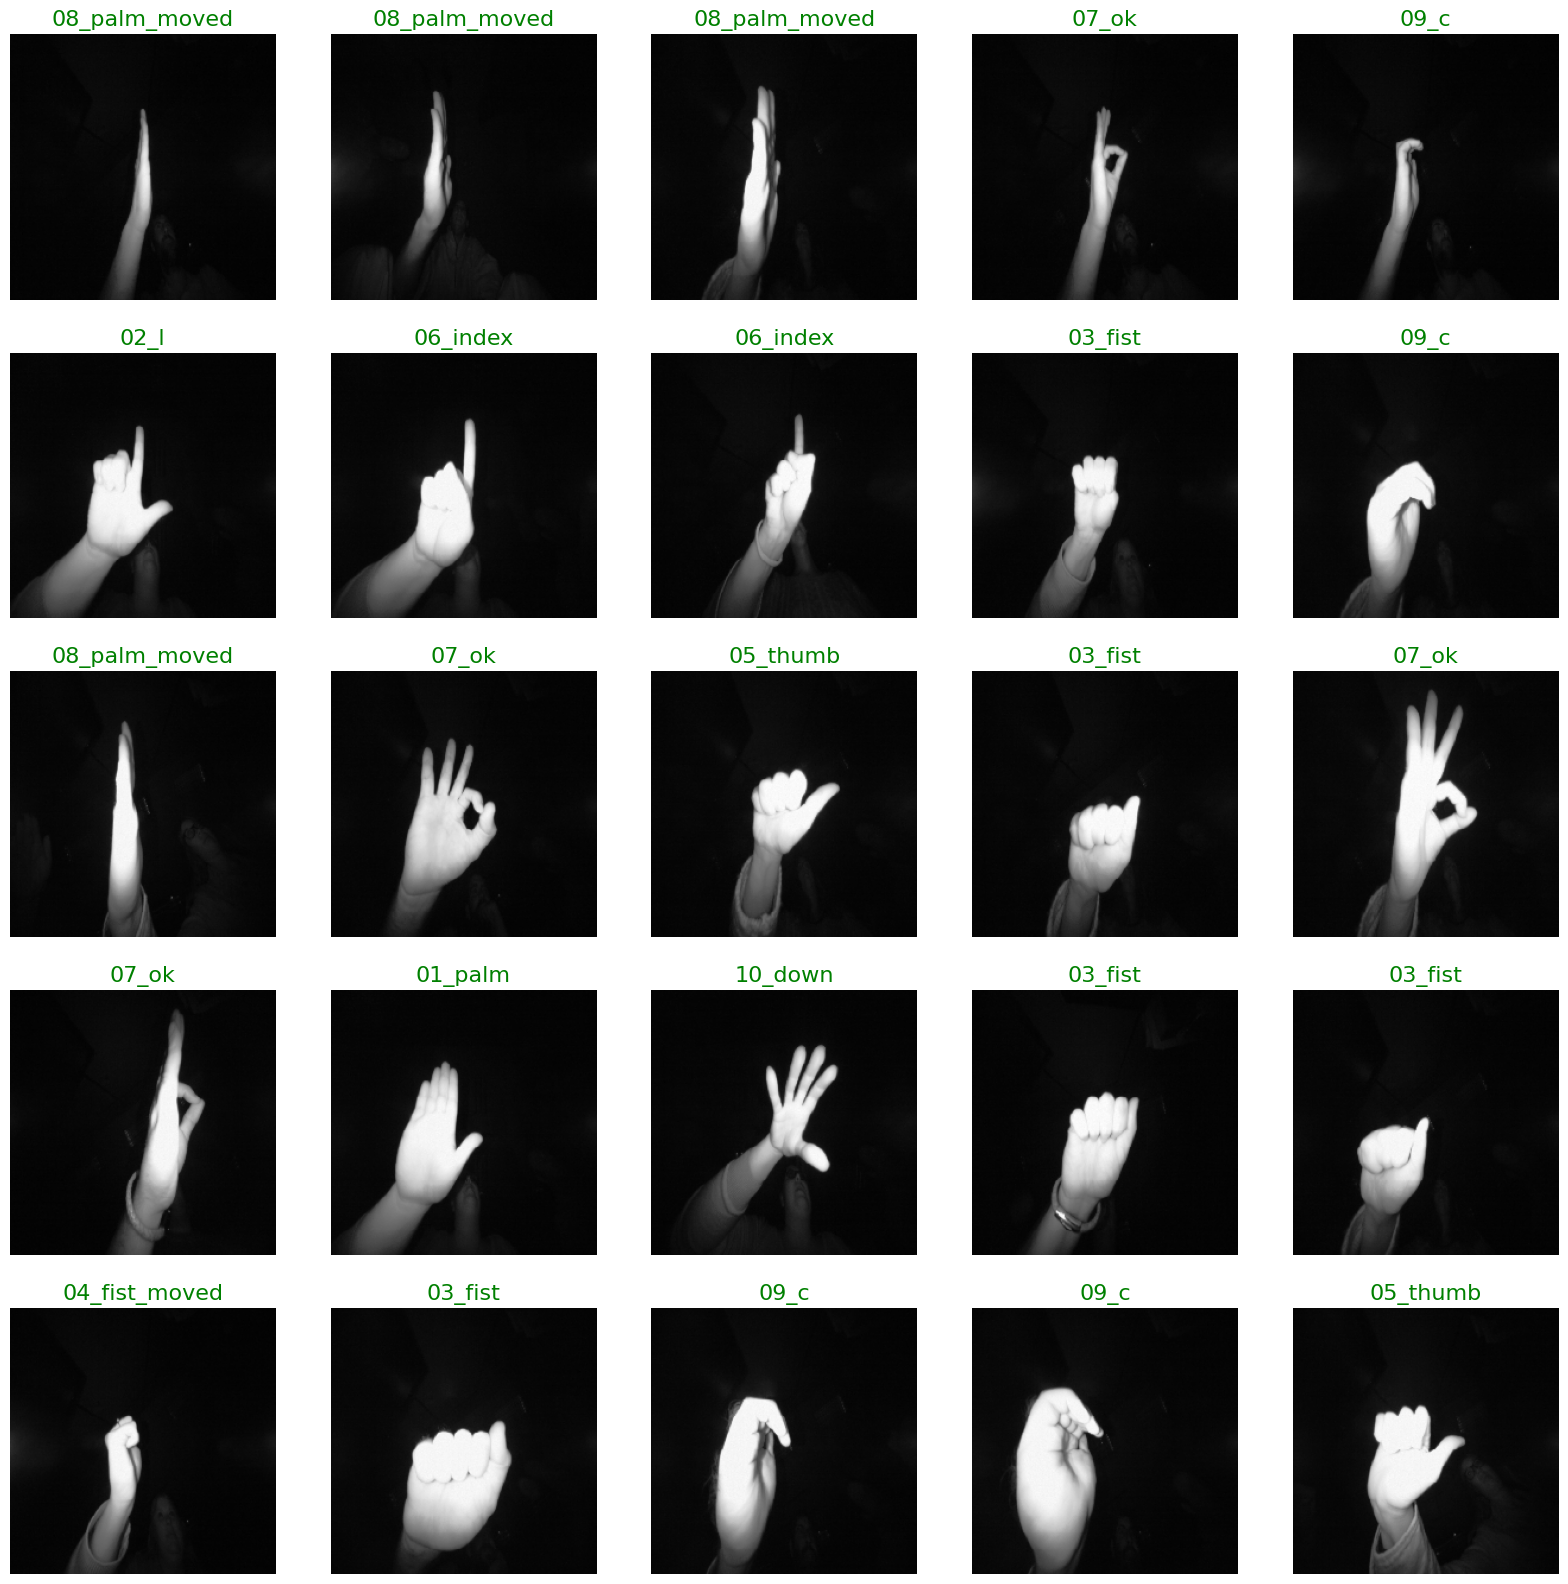

In [13]:
# Function to show hand gestures
def show_hand_gesture(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)
    for i in range(r):
        plt.subplot(5, 5, i+1)
        try:
            image = (images[i] + 1) / 2
            plt.imshow(image)
            index = np.argmax(labels[i])
            class_name = classes[index]
            plt.title(class_name, color="green", fontsize=16)
            plt.axis('off')
        except UnidentifiedImageError:
            print(f"Skipping file due to identification error.")
    plt.show()

show_hand_gesture(train)



In [14]:
# Define the model
model = Sequential([
    Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])



In [15]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

In [16]:
# Train the model
history = model.fit(train, epochs=2, validation_data=val, verbose=1)



Epoch 1/2
393/393 [==============================] - 11288s 29s/step - loss: 1.1108 - accuracy: 0.6649 - val_loss: 1.4965 - val_accuracy: 0.4713
Epoch 2/2
393/393 [==============================] - 11624s 30s/step - loss: 0.1202 - accuracy: 0.9691 - val_loss: 0.0218 - val_accuracy: 0.9975


In [17]:
# Save the model
model.save("hand_gesture_Model.h5")



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = train.class_indices
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]



123/123 [==============================] - 940s 8s/step


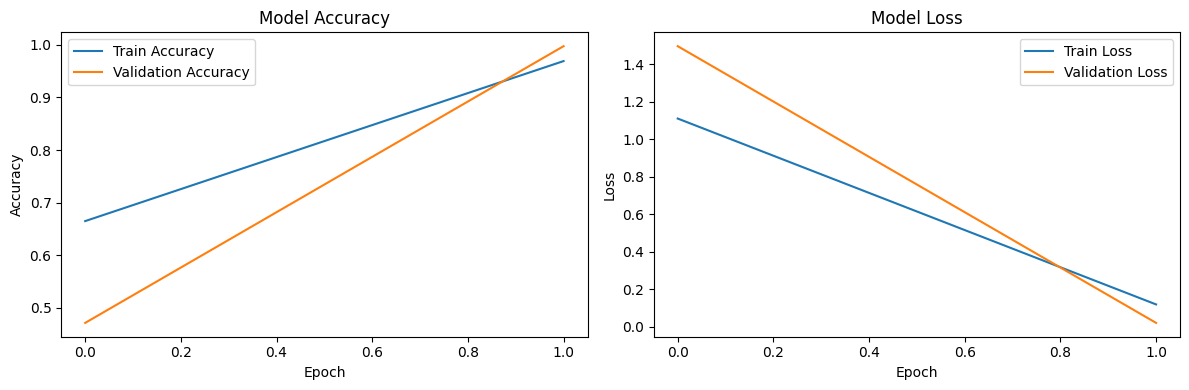

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()



In [20]:
# Evaluation
y_test = X_test['labels']
print(classification_report(y_test, pred2))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))



               precision    recall  f1-score   support

      01_palm       0.99      1.00      1.00       402
         02_l       1.00      0.99      1.00       399
      03_fist       1.00      0.99      1.00       395
04_fist_moved       1.00      1.00      1.00       429
     05_thumb       1.00      1.00      1.00       379
     06_index       1.00      1.00      1.00       384
        07_ok       1.00      1.00      1.00       390
08_palm_moved       1.00      1.00      1.00       396
         09_c       1.00      1.00      1.00       372
      10_down       1.00      1.00      1.00       379

     accuracy                           1.00      3925
    macro avg       1.00      1.00      1.00      3925
 weighted avg       1.00      1.00      1.00      3925

Accuracy of the Model: 99.9%


In [21]:
# Function to predict gestures
def predict_gesture(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    preprocessed_img = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_gesture = labels[predicted_class[0]]
    return predicted_gesture



In [22]:
# Example prediction
sample_image_path = X_test.iloc[0]['Images']
predicted_gesture = predict_gesture(model, sample_image_path)
print(f"Predicted gesture: {predicted_gesture}")


1/1 [==============================] - 1s 529ms/step
Predicted gesture: 03_fist
